In [6]:
from tensorflow.keras.applications.resnet import preprocess_input 
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.preprocessing import image
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPU")
    except RuntimeError as e:
        print("Memory growth setting failed:", e)

<b><font size = 5>Multiclass Resnet101 (BENIGN, BENIGN_WITHOUT_CALLBACK, MALIGNANT)</font></b>

In [7]:
DATA_DIR = r"D:\VSC Workspace\breast_cancer_CNN\dataset"

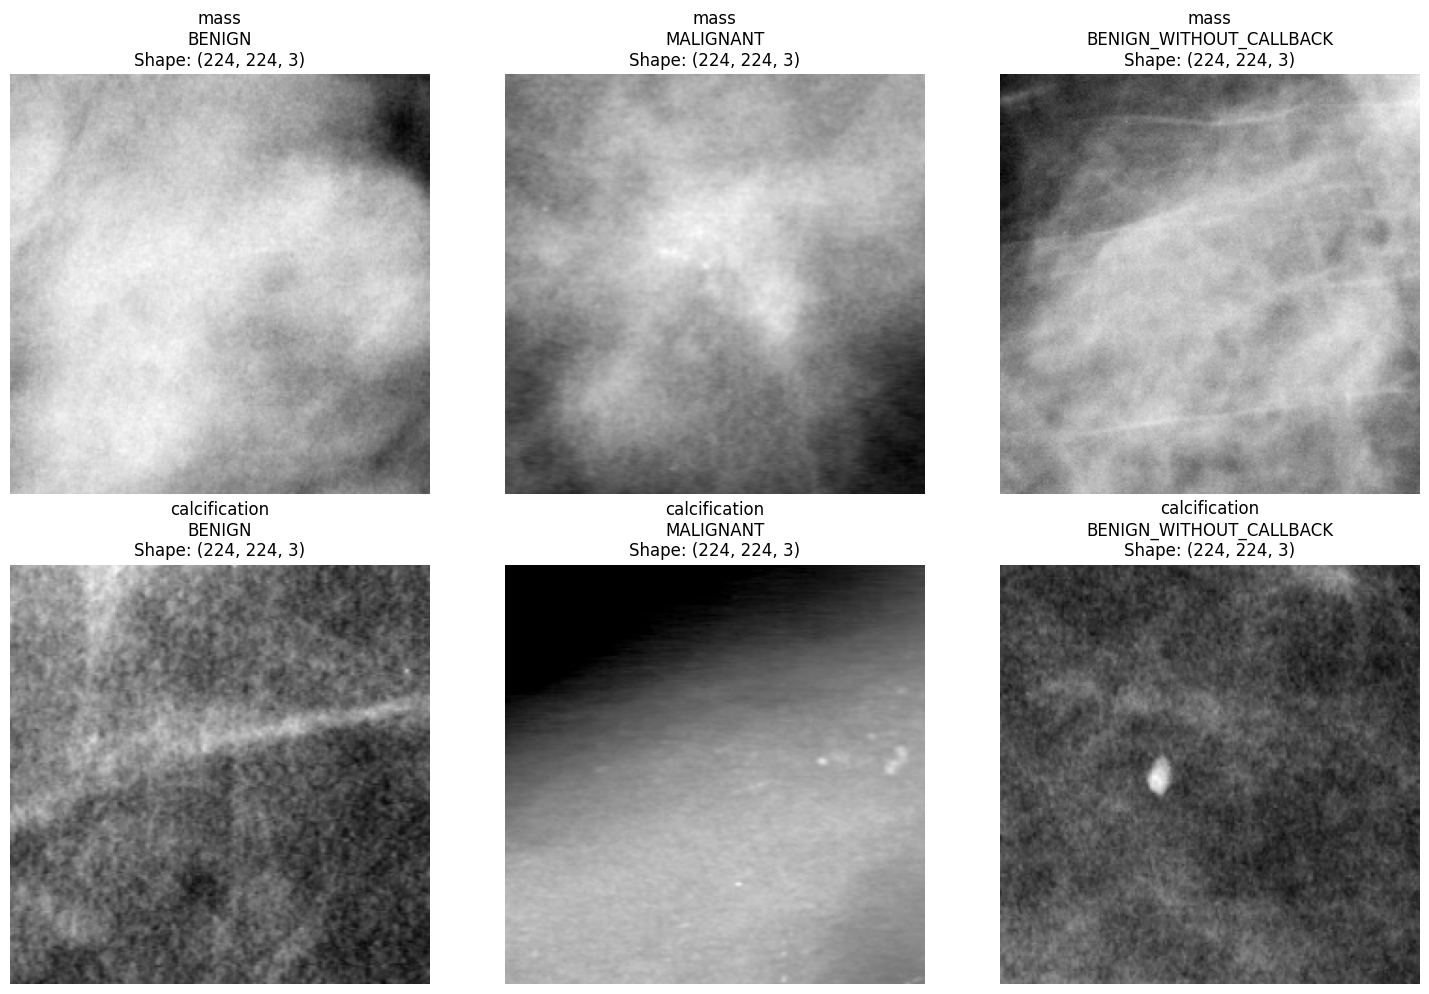

In [8]:
def display_sample_images(base_path, num_samples=3):
    categories = ['BENIGN', 'MALIGNANT', 'BENIGN_WITHOUT_CALLBACK']
    types = ['mass', 'calcification']
    
    fig = plt.figure(figsize=(15, 10))
    
    for type_idx, type_name in enumerate(types):
        for cat_idx, category in enumerate(categories):
            plot_idx = type_idx * len(categories) + cat_idx + 1
            
            path = os.path.join(base_path, type_name, 'train', 'cropped_files', category)
            try:
                image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                if image_files:
                    img_file = np.random.choice(image_files)
                    img_path = os.path.join(path, img_file)
                    
                    img = tf.keras.preprocessing.image.load_img(img_path)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    
                    plt.subplot(2, 3, plot_idx)
                    plt.imshow(img_array.astype(np.uint8))
                    plt.title(f"{type_name}\n{category}\nShape: {img_array.shape}")
                    plt.axis('off')
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")
    
    plt.tight_layout()
    plt.show()
display_sample_images(DATA_DIR)

In [9]:
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

train_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)

test_gen = image.ImageDataGenerator(
    dtype='float32',
    preprocessing_function=preprocess_input
)


In [10]:
mass_train_generator = train_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'mass/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

mass_val_generator = test_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'mass/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

print(mass_train_generator.class_indices)
print(mass_val_generator.class_indices)

Found 626 images belonging to 3 classes.


Found 339 images belonging to 3 classes.
{'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 1, 'MALIGNANT': 2}
{'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 1, 'MALIGNANT': 2}


In [11]:
calc_train_generator = train_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'calcification/train/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_val_generator = test_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'calcification/test/cropped_files'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

print(calc_train_generator.class_indices)
print(calc_val_generator.class_indices)

Found 749 images belonging to 3 classes.
Found 301 images belonging to 3 classes.
{'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 1, 'MALIGNANT': 2}
{'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 1, 'MALIGNANT': 2}


In [12]:
def create_model(input_shape=(224, 224, 3), num_classes=3, model_type="mass"):

    base_model = ResNet101(

        weights='imagenet',
        include_top=False,
        input_shape=input_shape

    )
    
    base_model.trainable = False
    
    for layer in base_model.layers:

        if isinstance(layer, tf.keras.layers.ReLU):

            layer_config = layer.get_config()
            new_layer = tf.keras.layers.LeakyReLU(alpha=0.0065)
            new_layer.name = layer.name
            layer_config['name'] = layer.name
            new_layer.from_config(layer_config)
            idx = base_model.layers.index(layer)
            base_model.layers[idx] = new_layer
    
    inputs = tf.keras.Input(shape=input_shape)

    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(180)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'resnet101_{model_type}')
    model.compile(

        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']

    )

    return model

In [13]:
callbacks = [

    tf.keras.callbacks.EarlyStopping(

        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True

    ),

    tf.keras.callbacks.ReduceLROnPlateau(

        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-6

    ),
    
]

In [14]:
print (f"Training Mass Model...")

mass_model = create_model(model_type="mass")
mass_history = mass_model.fit(

    mass_train_generator,
    validation_data=mass_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1

)

Training Mass Model...


d:\VSC Workspace\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10


d:\VSC Workspace\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.4624 - loss: 1.1792 - val_accuracy: 0.6018 - val_loss: 0.9402 - learning_rate: 5.0000e-04
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step - accuracy: 0.6105 - loss: 0.8684 - val_accuracy: 0.5634 - val_loss: 1.0116 - learning_rate: 5.0000e-04
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.6751 - loss: 0.7595 - val_accuracy: 0.6165 - val_loss: 0.9996 - learning_rate: 5.0000e-04
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6532 - loss: 0.7582 - val_accuracy: 0.4513 - val_loss: 1.3182 - learning_rate: 5.0000e-04
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.6747 - loss: 0.7405 - val_accuracy: 0.6195 - val_loss: 0.9821 - learning_rate: 5.0000e-04
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.7559 - loss: 0.5810 - val_accuracy: 0.6047 - val_loss: 1.0359 - learning_rate: 5.0000e-04
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.7672 - loss: 0.5691 - 

In [15]:
print("Training Calcification Model...")

calc_model = create_model(model_type="calcification")
calc_history = calc_model.fit(

    calc_train_generator,
    validation_data=calc_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
    
)

Training Calcification Model...
Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4803 - loss: 1.2454 - val_accuracy: 0.5615 - val_loss: 0.9044 - learning_rate: 5.0000e-04
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 112s 2s/step - accuracy: 0.6479 - loss: 0.7627 - val_accuracy: 0.5880 - val_loss: 0.8308 - learning_rate: 5.0000e-04
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.7363 - loss: 0.5722 - val_accuracy: 0.5781 - val_loss: 0.8239 - learning_rate: 5.0000e-04
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7145 - loss: 0.5979 - val_accuracy: 0.5847 - val_loss: 0.8117 - learning_rate: 5.0000e-04
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 88s 2s/step - accuracy: 0.7409 - loss: 0.5377 - val_accuracy: 0.5482 - val_loss: 0.8440 - learning_rate: 5.0000e-04
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 2s/step - accuracy: 0.7696 - loss: 0.4886 - val_accuracy: 0.5748 - val_loss: 0.8753 - learning_rate: 5.0000e-04
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 87s 

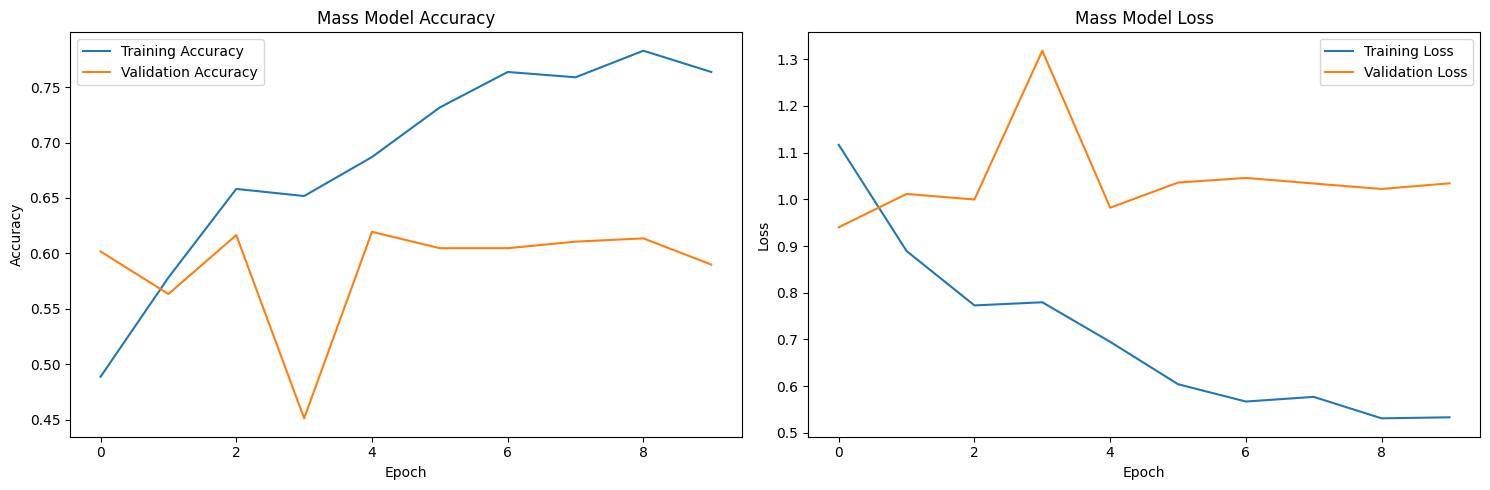

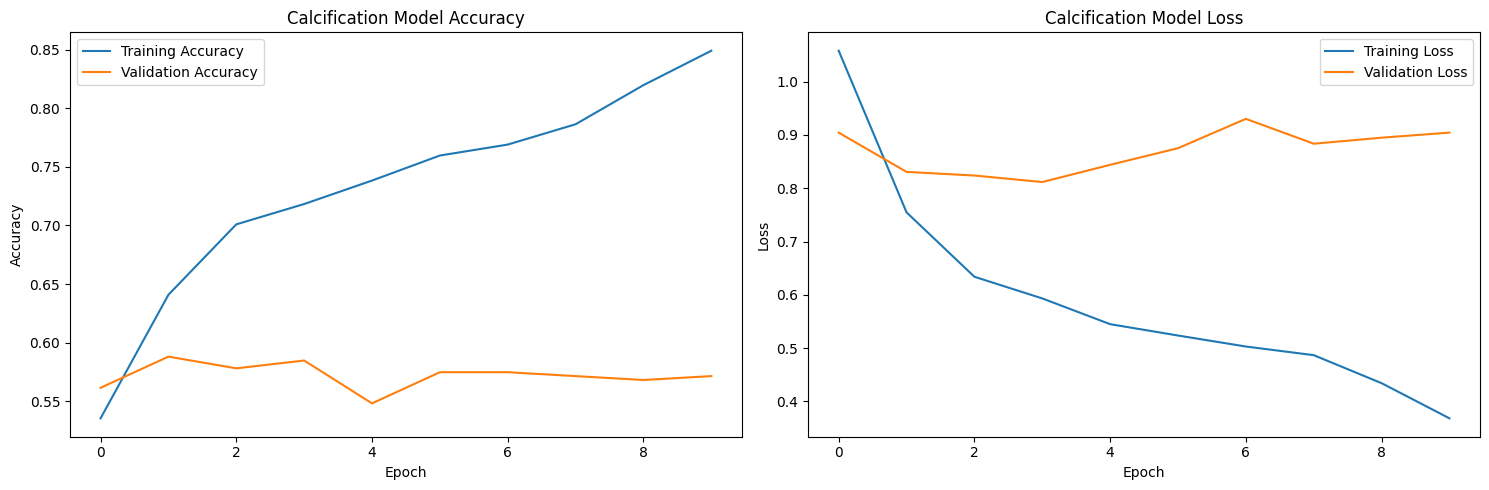

In [16]:
def plot_history(history, model_type):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_type} Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_type} Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(mass_history, 'Mass')
plot_history(calc_history, 'Calcification')


<b><font size = 5>Binary Resnet101 (BENIGN, MALIGNANT)</font></b>

In [17]:
DATA_DIR = r"D:\VSC Workspace\breast_cancer_CNN\cropped_dataset"

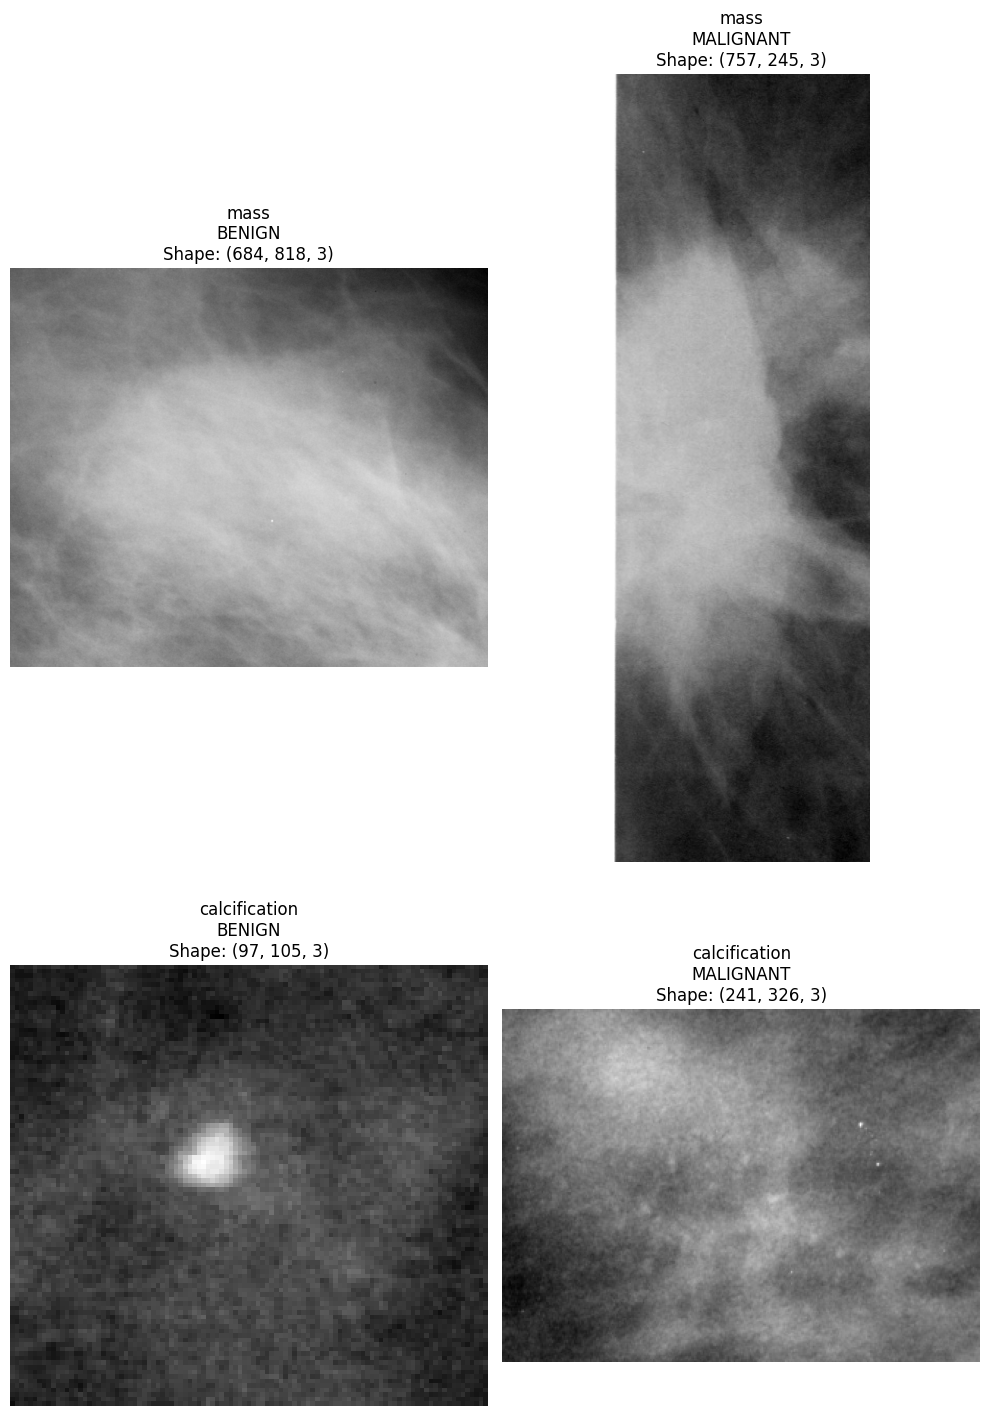

In [18]:
def display_sample_images(base_path, num_samples=3):
    categories = ['BENIGN', 'MALIGNANT']
    types = ['mass', 'calcification']
    
    fig = plt.figure(figsize=(10, 16))
    
    for type_idx, type_name in enumerate(types):
        for cat_idx, category in enumerate(categories):
            plot_idx = type_idx * len(categories) + cat_idx + 1
            
            path = os.path.join(base_path, type_name, 'train', category)
            try:
                image_files = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
                if image_files:
                    img_file = np.random.choice(image_files)
                    img_path = os.path.join(path, img_file)
                    
                    img = tf.keras.preprocessing.image.load_img(img_path)
                    img_array = tf.keras.preprocessing.image.img_to_array(img)
                    
                    plt.subplot(2, 2, plot_idx)
                    plt.imshow(img_array.astype(np.uint8))
                    plt.title(f"{type_name}\n{category}\nShape: {img_array.shape}")
                    plt.axis('off')
            except Exception as e:
                print(f"Error processing {path}: {str(e)}")
    
    plt.tight_layout()
    plt.show()
display_sample_images(DATA_DIR)

In [19]:
mass_train_generator = train_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'mass/train'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

mass_val_generator = test_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'mass/test'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

print(mass_train_generator.class_indices)
print(mass_val_generator.class_indices)

Found 551 images belonging to 2 classes.
Found 326 images belonging to 2 classes.
{'BENIGN': 0, 'MALIGNANT': 1}
{'BENIGN': 0, 'MALIGNANT': 1}


In [20]:
calc_train_generator = train_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'calcification/train'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

calc_val_generator = test_gen.flow_from_directory(
    os.path.join(DATA_DIR, 'calcification/test'),
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical'
)

print(calc_train_generator.class_indices)
print(calc_val_generator.class_indices)

Found 554 images belonging to 2 classes.
Found 290 images belonging to 2 classes.
{'BENIGN': 0, 'MALIGNANT': 1}
{'BENIGN': 0, 'MALIGNANT': 1}


In [21]:
def create_model(input_shape=(224, 224, 3), num_classes=2, model_type="mass"):

    base_model = ResNet101(

        weights='imagenet',
        include_top=False,
        input_shape=input_shape

    )
    
    base_model.trainable = False
    
    for layer in base_model.layers:

        if isinstance(layer, tf.keras.layers.ReLU):

            layer_config = layer.get_config()
            new_layer = tf.keras.layers.LeakyReLU(alpha=0.0065)
            new_layer.name = layer.name
            layer_config['name'] = layer.name
            new_layer.from_config(layer_config)
            idx = base_model.layers.index(layer)
            base_model.layers[idx] = new_layer
    
    inputs = tf.keras.Input(shape=input_shape)

    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(180)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.01)(x)
    
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'resnet101_{model_type}')
    model.compile(

        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']

    )

    return model

In [22]:
print ("Training Mass Model...")

mass_model = create_model(model_type="mass")
mass_history = mass_model.fit(

    mass_train_generator,
    validation_data=mass_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1

)

Training Mass Model...
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5921 - loss: 0.8252 - val_accuracy: 0.6810 - val_loss: 0.6029 - learning_rate: 5.0000e-04
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.6702 - loss: 0.5902 - val_accuracy: 0.6994 - val_loss: 0.5849 - learning_rate: 5.0000e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7089 - loss: 0.5518 - val_accuracy: 0.7025 - val_loss: 0.6043 - learning_rate: 5.0000e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7644 - loss: 0.4607 - val_accuracy: 0.7117 - val_loss: 0.5986 - learning_rate: 5.0000e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7628 - loss: 0.4539 - val_accuracy: 0.6748 - val_loss: 0.6670 - learning_rate: 5.0000e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - accuracy: 0.7841 - loss: 0.4533 - val_accuracy: 0.7055 - val_loss: 0.6205 - learning_rate: 5.0000e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - a

In [23]:
print("Training Calcification Model...")

calc_model = create_model(model_type="calcification")
calc_history = calc_model.fit(

    calc_train_generator,
    validation_data=calc_val_generator,
    epochs=10,
    callbacks=callbacks,
    verbose=1
    
)

Training Calcification Model...
Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.5563 - loss: 1.0430 - val_accuracy: 0.6276 - val_loss: 0.8037 - learning_rate: 5.0000e-04
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.7397 - loss: 0.5962 - val_accuracy: 0.6241 - val_loss: 0.6394 - learning_rate: 5.0000e-04
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.7674 - loss: 0.4607 - val_accuracy: 0.6448 - val_loss: 0.6126 - learning_rate: 5.0000e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - accuracy: 0.7901 - loss: 0.4152 - val_accuracy: 0.6448 - val_loss: 0.6706 - learning_rate: 5.0000e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - accuracy: 0.8112 - loss: 0.3552 - val_accuracy: 0.6172 - val_loss: 0.7440 - learning_rate: 5.0000e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.8116 - loss: 0.4083 - val_accuracy: 0.6034 - val_loss: 0.7776 - learning_rate: 5.0000e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 78s 2s

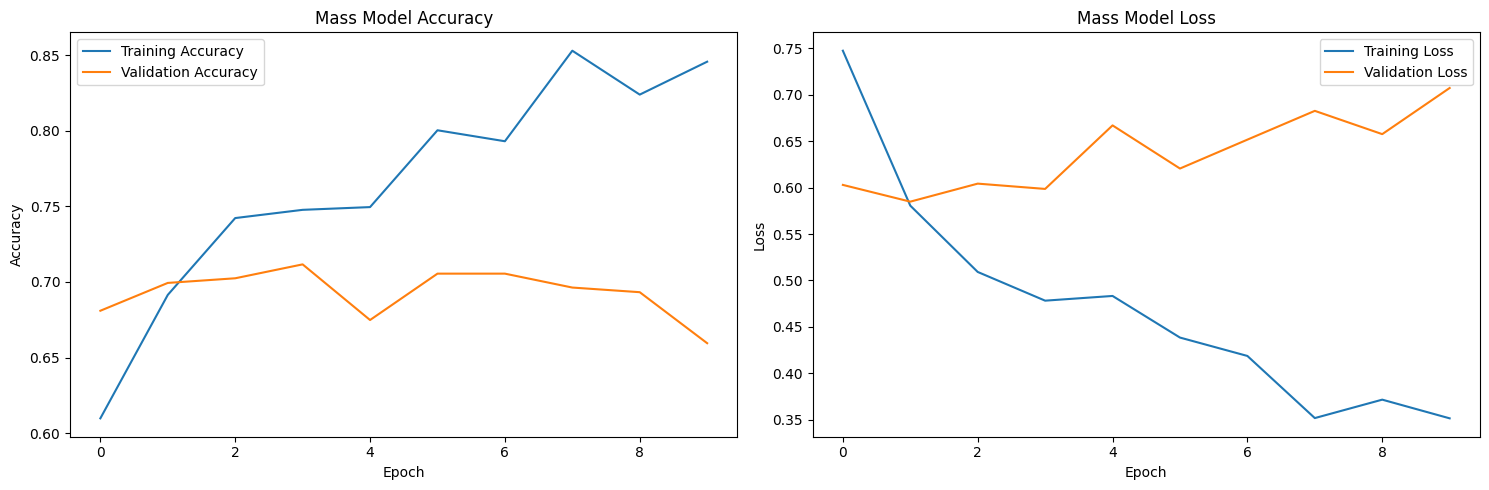

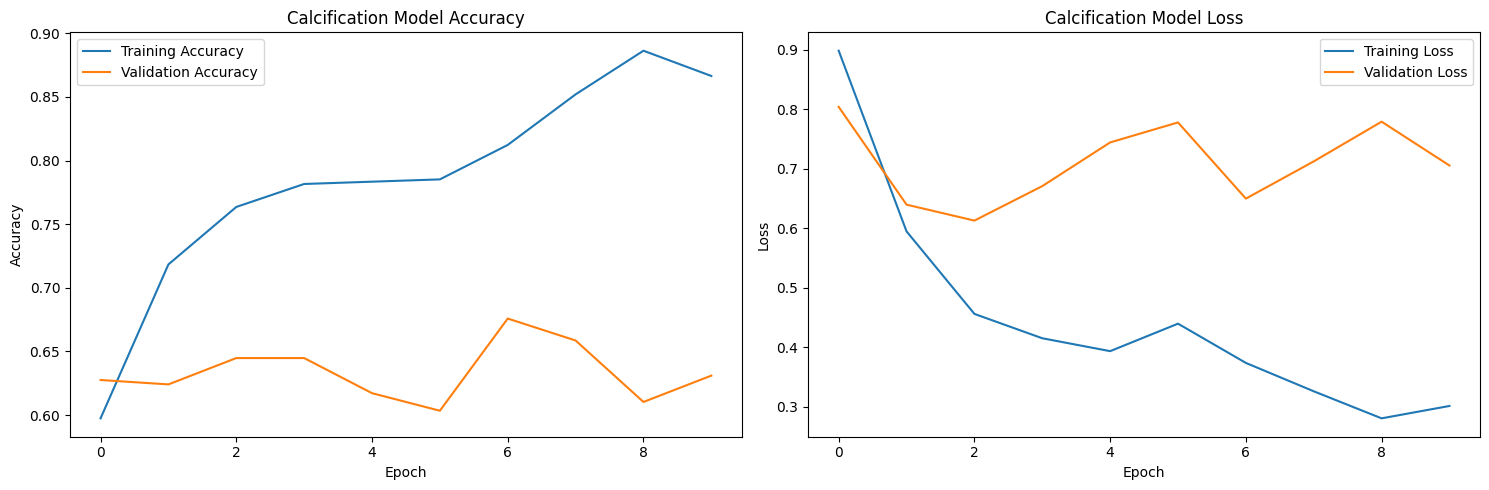

In [24]:
def plot_history(history, model_type):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_type} Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_type} Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_history(mass_history, 'Mass')
plot_history(calc_history, 'Calcification')
